In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import atan2, exp
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10,10) # Should be run twice or doesn't work

np.random.seed(1234)

## Functions for data generation

In [2]:
import numpy as np
from math import atan2, sqrt


def generate_landmarks(n, map_shape=(100, 100)):
    """
    Generate the coordinates of n lamndmarks at random, following a random uniform distribution centered on 0.
    Return a matrix of shape (n, 2) with x coordinates as first column and y coordinates as second.
        n : number of landmarks
        map_shape : tuple for the size of the map
    """
    map_shape = np.array(map_shape)
    return np.random.uniform(low=-map_shape/2, high=map_shape/2, size=(n, 2))


def generate_path(controls, f, Q, position=np.array([0,0,0]), **fkwargs):
    """
    Generate the path taken by the robot from given starting position, controls and an f function.
    Return a (n_iter, 3) matrix with the position of the robot for each iteration.
        n_iter : number of iterations
        controls : (n_iter, 2) array, each column giving respectively velocity and direction
        f : function used to get the new position. Must take the arguments(x_t, u_t) and any other keywords arguments
        Q : covariance matrix to get the noisy controls
        position: starting_position, usually(0, 0, 0)
        fkwargs: additional keyword arguments for f
    """
    path = [position]
    for c in controls:
        # Add noise to the controls
        noisy_controls = np.random.multivariate_normal(c, Q)
        # Determine the new position
        position = f(position, noisy_controls, **fkwargs)
        path.append(position)
    return np.array(path)

def f_paper(x_previous, u_t, dt=1, B=1.5):
    """Implementation of the path in 4.1"""
    new_angle = x_previous[2] + u_t[1]
    change = np.array([np.cos(new_angle),
                       np.sin(new_angle),
                       np.sin(u_t[1])/B]) * u_t[0] * dt
    return x_previous + change

def generate_observations(path, landmarks, w0, R, sigma_0, sigma_1):
    """From a path and a given map of landmarks, generate the observations y_t.
    We assume the robot can see every landmark at every iteration.
    We replace arctan wih atan2 as it gives the angle in the rage [pi, -pi]
    path : array, dimension (n_iter, 2)"""
    observations = np.empty((len(path), len(landmarks), 2), dtype=float)
    for s in range(len(path)):
        for i in range(len(landmarks)):
            diff_pos_landmark = landmarks[i] - path[s, 0:2]
            observations[s, i, 0] = sqrt(np.sum(diff_pos_landmark**2))
            observations[s, i, 1] = atan2(diff_pos_landmark[1], diff_pos_landmark[0]) - path[s, -1]
            # Add noise
            mix_choice = np.random.binomial(1, w0)
            varcov_mat = R * sigma_1 ** 2 if mix_choice else R * sigma_0 ** 2
            delta_s_i = np.random.multivariate_normal([0,0], varcov_mat)
            observations[s, i] += delta_s_i
    return observations

def convert_obs_to_coord(pos, observation):
    """Convert a batch of observations to coordinates given a position."""
    absolute_angle = pos[-1] + observation[:, 1]
    distance = observation[:, 0]
    landmark_pos = np.empty_like(observation)
    landmark_pos[:, 0] = pos[0] + distance * np.cos(absolute_angle)
    landmark_pos[:, 1] = pos[1] + distance * np.sin(absolute_angle)
    return landmark_pos


## Functions for Online_EM

In [3]:
import numpy as np
import numpy.random as npr
from scipy.optimize import minimize

def online_expectation(sample, u_t, y_t, N, r, rho, w0, t, theta,  R, sigma_0, sigma_1, Q):
    """Compute a step of the online expectation
    sample : sample of the approximated position xi and a weight at t-1, size(n, 4)
    u_t : order at time t, size(3, 1)
    y_t : observations of the landmark at time t, size(2,q)
    n : number of particles
    r : probability for the bernouli distribution choosing the mixture model
    R : variance/covariance matrix to be used in the mixture (will be multiplied by sigma_0 or sigma_1)
    rho : previous sample helping approximating the mean to calculate likelyhood, size(n,q, 2)
    w0 : set parameter for the "real" r
    t : current iteration
    theta: map parameter"""
    # Draw a sample
    q = len(y_t)
    selection_indexes = npr.choice(np.arange(len(sample)), size=N, p=sample[:, -1])
    sample_xi = sample[selection_indexes, 0:3]
    sample_weights = sample[selection_indexes, -1]

    # Sample from the pi_kernel the new xi_t
    new_xi = sample_from_pi(sample_xi, u_t, y_t)

    # Sample the choice of gaussian for the mixture
    mixture_i = npr.binomial(1, r, size=(N, q))
    mixture_sum = mixture_i.sum(axis=1)

    # Get the new weights
    ww_dens = g_theta(theta, y_t, new_xi, mixture_i) * m_function(new_xi, sample_xi, u_t)/ pi_distrib(new_xi, sample_xi, u_t, y_t)
    new_weights = ww_dens * (((1 - w0)/r) ** mixture_sum) * ((w0/(1 - r)) ** (q - mixture_sum))
    new_weights = new_weights/new_weights.sum(axis=1)  # Normalize the weigths

    new_sample = np.hstack((new_xi, new_weights))

    ## Stochastic approximation step
    gamma_t_i = 1/t**0.8 # Should not be hard coded
    new_rho = gamma_t_i * stat_i(new_xi, mixture_i, y_t) + \
                (1 - gamma_t_i) * sum_approximation_weights(sample_xi,
                                                            sample_weights,
                                                            new_xi, u_t, y_t,
                                                            rho)

    approx_expect = (new_sample[:, -1] * new_rho).sum(axis=0)

    return new_sample, new_rho, approx_expect


def sum_approximation_weights(sample_xi, sample_weigths, new_xi, u_t, y_t, rho):
    """Fonction used in the determination of the new rho in the stochastic approximation step"""
    q = len(sample_xi)
    n = len(y_t)
    out_matrix = np.empty((q, n), dtype=float)
    for i in range(q):
        for k in range(n):
            out_matrix[k, i] = (sample_weigths * m_function(new_xi[k], sample_xi, u_t) * rho[:, i]).sum() +\
                                (sample_weigths * m_function(new_xi[k], sample_xi, u_t)).sum()
    return out_matrix

## Functions whose expression is missing

def g_theta(theta, y_t, xi, mixture_i, R, sigma_O, sigma_1):
    """g theta as an expression we can evaluate"""
    
    out_matrix = np.zeros_like(mixture_i)
    
    
    # Calculate the determinant of the covariance matrix 
    det_matrix = np.zeros_like(mixture_i)
    I_indicator_0 = cov_matrix_multiplicator[mixture_i == 0]
    I_indicator_1 = cov_matrix_multiplicator[mixture_i == 1]
    
    det_R = np.linalg.det(R)
    det_matrix[I_indicator_0] = sigma_0 ** 2 * det_R
    det_matrix[I_indicator_1] = sigma_1 ** 2 * det_R
    
    for i in range(len(landmarks)):
        diff_pos_landmark = landmarks[i] - path[s, 0:2]
        observations[s, i, 0] = sqrt(np.sum(diff_pos_landmark**2))
        observations[s, i, 1] = atan2(diff_pos_landmark[1], diff_pos_landmark[0]) - path[s, -1]
        # Add noise
    
    diff_pos_landmark = theta[i] - xi[s, 0:2]
    observations[s, i, 0] = sqrt(np.sum(diff_pos_landmark**2))
    observations[s, i, 1] = atan2(diff_pos_landmark[1], diff_pos_landmark[0]) - path[s, -1]
            
    
    for i in range(len(out_matrix)):
        diff_pos_landmarks = theta - xi[i, 0:2]
        obs_xi = np.array([sqrt(np.sum(diff_pos_landmark**2)),
                atan2(diff_pos_landmark[1], diff_pos_landmark[0]) - xi[i, -1]])
        mat_to_multiply = y_t - obs_xi
        
        inside_exp = -1/2 * np.matmul(np.matmul(mat_to_multiply.T, np.linalg.inv),
                                      mat_to_multiply)
        out_matrix[i] = exp(inside_exp) / (2 * np.pi * sqrt(det_matrix[i]))
        
    return out_matrix


def m_function(x_t, x_previous, u_t, Q):
    """density function of the state transition model"""
    det_Q = np.linalg.det(Q)
    diff_pos = x_t - x_previous
    for i in range(len(out_matrix)):
        gamma = atan2(diff_pos[i, 0], diff_pos[i, 1])
        v = diff_pos[i, -1] * B / (dt * sin(gamma))
        f_inv = np.array(gamma, v)
        inside_exp = np.matmul(f_inv.T, np.linalg.inv(Q)), f_i
        out_matrix[i] = exp(inside_exp) / (2 * np.pi * sqrt(Q))

    
    
    return out_matrix


def pi_distrib(x_t, x_previous, u_t,  y_t):
    """Candidate density"""
    pass


def sample_from_pi(xi, u_t, y_t):
    pass


def stat_i(x_t, i_t, y_t):
    pass


def Xi(theta):
    """Function linked to the sufficient statistics S """
    pass


def maximization_step(approx_expect, theta):
    # We can maximize each column
    # Approximate the expectation of S_t,i given y_1:t
    approx_expect = approx_expect.T
    fitted_theta = np.empty_like(theta)
    for i in range(len(approx_expect)):
        f_to_maximize = lambda theta_tomax: -np.matmul(approx_expect[i], Xi(theta_tomax))
        f_to_minimize = lambda theta_tomax : -1 * f_to_maximize(theta_tomax)
        result = minimize(f_to_minimize, theta[i]) # the function should be quadratic so default options should work
        if result.success:
            fitted_theta[i] = result.x
        else: raise ValueError(result.message)
    return fitted_theta

# Run

## Data generation

In [39]:
# Give a list of instructions to the robot
T = 1000
q = 10

# Straigth line
u_s = np.ones((T, 2))
u_s[:, 1] = 0

# Tries to make circles
u_c = np.ones((T, 2))/10
u_c[:, 1] = np.pi/(T/45)

# Tries to make an "8" shape
u_8 = np.ones((T, 2))/5
u_8[0:T//2, 1] = np.arange(T//2) * 2 * np.pi/T
u_8[T//2:T, 1] = -np.arange(T//2) * 2 * np.pi/T

# Chose an u
u = u_c

# Generate the path with the f from the paper
Q =  np.diag([0.5**2, np.pi/60])/10
path = generate_path(u, f_paper, Q, dt=0.5, B=1)

# Generate the landmarks
# It can be obviously be made independently 
#from the path but we choose to have a nice "scale" representation
farther_from_0 = np.abs(path[:, 0:2]).max()
landmarks = generate_landmarks(q, map_shape=(farther_from_0, farther_from_0))

# Generate observations
R = np.array([0.25, 0.01, 0.01, np.pi/60]).reshape(2,2)/20
obs = generate_observations(path, landmarks, 0.5, R, 1, 5 )


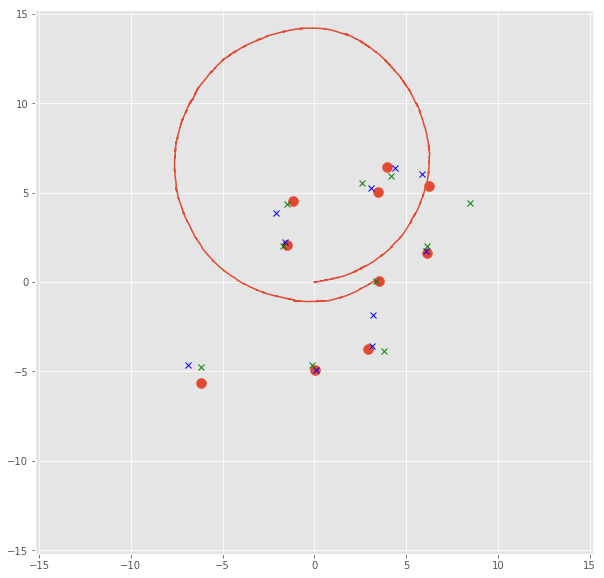

In [40]:
plt.plot(path[: , 0], path[:, 1])
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=100)
plt.xlim(-np.abs(path[:, 0:2]).max() - 1 , np.abs(path[:, 0:2]).max() + 1)
plt.ylim(-np.abs(path[:, 0:2]).max() - 1, np.abs(path[:, 0:2]).max() + 1)

# Plot the first observations in blue
obs_pol_coordinates = convert_obs_to_coord(path[0], obs[0])
plt.plot(obs_pol_coordinates[:, 0], obs_pol_coordinates[:, 1], 'bx')

# Plot the last observations in green
obs_pol_coordinates = convert_obs_to_coord(path[-1], obs[-1])
plt.plot(obs_pol_coordinates[:, 0], obs_pol_coordinates[:, 1], 'gx')
plt.show()

## Online_EM algorithm

In [ ]:
N = 1000 # Size of the filter

# Initialize the values used in expectation step
rho = np.zeros(N, q)
sample = np.zeros(N, 4) # Initialize sample on 0 and uniform weigths
sample[:, 3] = 1/N

# Initialize the map parameter with a uniform distribution
theta = generate_landmarks(q, map_shape=(farther_from_0, farther_from_0))

mean_samples = np.zeros(N, 3)

nmin_update = 0 # Gather enough info before maximizing the likelihood (otherwise risk of degeneraxy of the likelyhood)

for step in range(T):
    sample, rho, approx_expect = online_expectation(sample, u[step], obs[step], N, 
                                                    r=w0, rho=rho, w0=w0, step=step, theta=theta,
                                                    R=R, sigma_0=1, sigma_1=5, Q=Q)
    if step >= nmin_update:
        mean_samples[step] = sample.mean(axis=1) # Approximation of the path for each step
        theta = maximization_step(approx_expect, theta)
    

## Plotting the estimations

In [ ]:
# Plot the true path and landmarks
plt.plot(path[: , 0], path[:, 1], landmarks[:, 0], landmarks[:, 1], 'ro')
plt.xlim(-np.abs(path[:, 0:2]).max() - 1 , np.abs(path[:, 0:2]).max() + 1)
plt.ylim(-np.abs(path[:, 0:2]).max() - 1, np.abs(path[:, 0:2]).max() + 1)

# Plot the estimated path by the mean of each iteration
plt.plot(mean_samples[:, 0], mean_samples[:, 1], 'g-')

# Plot the last estimation of the map parameter
plt.plot(theta[:, 0], theta[:, 1], 'go')

plt.show()